<a href="https://colab.research.google.com/github/Jongui/PlayPongWithLeNet/blob/main/LeNet_Pong_with_loading_data_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium
!pip install gymnasium[atari]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.9 MB/s eta 0:00:00


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
import tensorflow as tf

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import random
from IPython.display import clear_output
import ale_py
import matplotlib.pyplot as plt

env = gym.make('ALE/Pong-v5', frameskip=1, render_mode = 'rgb_array')

# Environment preprocessing
env = AtariPreprocessing(env)
# Stack four frames
env = FrameStackObservation(env, 4)

In [ ]:
class AbstractAgent:
    def __init__(self, env):
        self.env = env
        self.actions = []

    def take_step(self, current_state):
        print("Take step")

In [ ]:
done_array = []
class GamePlay:
    def __init__(self, env, total_epochs, episode_batch_size):
        self.total_epochs = total_epochs
        self.env = env
        self.episode_batch_size = episode_batch_size
        self.cpu_scores, self.agent_scores = [],[]
        self.rounds = []

    def plot_results(self):
        # plot lines
        plt.plot(self.rounds, self.agent_scores, label = "Agent Scores")
        # plt.plot(self.rounds, self.cpu_scores, label = "CPU Scores")
        plt.legend()
        plt.show()

    def print_current_score(self,agent_score, cpu_score, episode, agent_total_score, cpu_total_score):
        clear_output(wait=True)
        print(f"Episode: {episode}")
        print(f"Agent {agent_score} x {cpu_score} CPU")
        if episode % self.episode_batch_size == 0:
            print(f"Agent {agent_total_score} x {cpu_total_score} CPU")

    def game_play(self,agent):

        self.cpu_scores, self.agent_scores = [],[]
        self.rounds = []
        games_played, cpu_wins, agent_wins, agent_total_score, cpu_total_score = 0, 0, 0, 0, 0
        agent_10_score, cpu_10_score = 0, 0
        epochs = 0
        for i in range(0, self.total_epochs):
            current_state = self.env.reset()[0]
            done = False
            cpu_score, agent_score = 0, 0
            while not done:
                next_state, reward, done, info, info2 = agent.take_step(current_state)
                current_state = next_state
                done_array.append(done)
                if reward < 0:
                    reward = reward * -1
                    cpu_score = cpu_score + reward
                else:
                    agent_score = agent_score + reward

                self.print_current_score(agent_score, cpu_score, i, agent_total_score, cpu_total_score)
                if done == True:
                    print("Game finished")
                    games_played = games_played + 1
                    agent_total_score = agent_total_score + agent_score
                    cpu_total_score = cpu_total_score + cpu_score
                    if cpu_score == 21:
                        cpu_wins = cpu_wins + 1
                    else:
                        agent_wins = agent_wins + 1

                    agent_10_score = agent_10_score + agent_score
                    cpu_10_score = cpu_10_score + cpu_score
                    self.agent_scores.append(agent_score)
                    #if games_played % self.episode_batch_size == 0:
                    #    self.cpu_scores.append(agent_10_score)
                    #    self.agent_scores.append(agent_10_score)
                    #    self.rounds.append(games_played)
                    #    agent_10_score, cpu_10_score = 0, 0

            epochs += 1
        clear_output(wait=True)
        print(f"Epochs: {epochs}")
        print(f"Agent Wins: {agent_wins}")
        print(f"CPU Wins: {cpu_wins}")
        print(f"Agent Total Score: {agent_total_score}")
        print(f"CPU Total Score: {cpu_total_score}")
        # self.plot_results()
        return self.agent_scores, self.rounds

game_play = GamePlay(env=env,total_epochs=1000,episode_batch_size=20)

In [ ]:
class RandomAgent(AbstractAgent):
    def __init__(self, env):
        self.env = env
        self.actions = env.action_space
    def take_step(self,current_state):
        next_state, reward, done, info, info2 = self.env.step(self.actions.sample())
        return next_state, reward, done, info, info2


In [ ]:
class LeNetAgent(AbstractAgent):
    def __init__(self, env):
        self.env = env
        self.num_actions = 2
        self.model = self._create_q_model()
        self.model_target = self._create_q_model()

        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

        self.gamma = 0.99  # Discount factor for past rewards
        self.epsilon = 1.0  # Epsilon greedy parameter
        self.epsilon_min = 0.1  # Minimum epsilon greedy parameter
        self.epsilon_max = 1.0  # Maximum epsilon greedy parameter
        self.epsilon_interval = (
          self.epsilon_max - self.epsilon_min
        )  # Rate at which to reduce chance of random action being taken
        self.batch_size = 32  # Size of batch taken from replay buffer
        self.max_steps_per_episode = 10000
        self.max_episodes = 200  # Limit training episodes, will run until solved if smaller than 1

        self.actions_space =[2, 5]

        # Experience replay buffers
        self.action_history = []
        self.state_history = []
        self.state_next_history = []
        self.rewards_history = []
        self.done_history = []
        self.episode_reward_history = []
        self.running_reward = 0
        self.episode_count = 0
        # Number of frames to take random action and observe output
        self.epsilon_random_frames = 50000
        # Number of frames for exploration
        self.epsilon_greedy_frames = 1000000.0
        # Maximum replay length
        # Note: The Deepmind paper suggests 1000000 however this causes memory issues
        self.max_memory_length = 100000
        # Train the model after 4 actions
        self.update_after_actions = 16
        # How often to update the target network
        self.update_target_network = 10000
        # Using huber loss for stability
        self.loss_function = keras.losses.Huber()
        self.state = None
        # Count Q-Values and Random actions
        self.q_action_taken, self.random_actions_taken = [], []
        self.frame_count = 0
        self.done_count = 0

    def take_step(self,current_state):
        self.state = current_state
        self.frame_count += 1
        # Use epsilon-greedy for exploration
        action = 0
        if self.epsilon > np.random.rand(1)[0] or self.state is None:
            # Take random action
            action = np.random.choice(self.num_actions)
            self.q_action_taken.append(0)
            self.random_actions_taken.append(1)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = keras.ops.convert_to_tensor(self.state)
            state_tensor = keras.ops.expand_dims(state_tensor, 0)
            action_probs = self.model(state_tensor, training=False)
            # Take best action
            action = keras.ops.argmax(action_probs[0]).numpy()
            self.q_action_taken.append(1)
            self.random_actions_taken.append(0)

        # Decay probability of taking random action
        self.epsilon -= self.epsilon_interval / self.epsilon_greedy_frames
        self.epsilon = max(self.epsilon, self.epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, info, info2 = env.step(self.actions_space[action])

        # Save actions and states in replay buffer
        if self.state is not None:
          self.action_history.append(action)
          self.state_history.append(self.state)
          self.state_next_history.append(state_next)
          self.done_history.append(done)
          self.rewards_history.append(reward)

        self.state = state_next
        if done:
            self.done_count += 1

        # Update after 10 game end
        if self.done_count == 10:
            self.done_count = 0

            # Using list comprehension to sample from replay buffer
            state_sample = self.state_history
            state_next_sample = self.state_next_history
            rewards_sample = self.rewards_history
            action_sample = self.action_history

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            state_tensor = keras.ops.convert_to_tensor(state_next_sample)
            future_rewards = self.model_target.predict(state_tensor)
            keras_sample = keras.ops.amax(
              future_rewards, axis=1
            )
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + self.gamma * keras.ops.amax(
              future_rewards, axis=1
            )

            # Create a mask so we only calculate loss on the updated Q-values
            masks = keras.ops.one_hot(action_sample, self.num_actions)

            with tf.GradientTape() as tape:
              # Train the model on the states and updated Q-values
              state_tensor = keras.ops.convert_to_tensor(state_sample)
              q_values = self.model(state_tensor)

              # Apply the masks to the Q-values to get the Q-value for action taken
              q_action = keras.ops.sum(keras.ops.multiply(q_values, masks), axis=1)
              # Calculate loss between new Q-value and old Q-value
              loss = self.loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

            # update the the target network with new weights
            self.model_target.set_weights(self.model.get_weights())
            # Log details
            self.running_reward = np.mean(self.rewards_history)
            template = "running reward: {:.2f} at frame count {}"
            print(template.format(self.running_reward, self.frame_count))

            # Experience replay buffers
            self.action_history = []
            self.state_history = []
            self.state_next_history = []
            self.rewards_history = []
            self.done_history = []
            self.episode_reward_history = []
            self.frame_count = 0

        return state_next, reward, done, info, info2

    def _create_q_model(self):
        # Network defined by the Deepmind paper
        return keras.Sequential(
            [
                layers.InputLayer(input_shape = (4, 84, 84)),
                layers.Flatten(),
                layers.Dense(units = 300, activation = 'relu'),
                layers.Dense(100, activation="relu"),
                layers.Dense(self.num_actions, activation="linear"),
            ]
        )


In [ ]:
import pandas as pd
dataset = pd.read_csv('/content/drive/My Drive/Reinforcement Learning/Random Agent Results v2.csv')
random_score_file = dataset.values
random_score = []
for fl in random_score_file:
  random_score.append(fl[1])
dataset = pd.read_csv('/content/drive/My Drive/Reinforcement Learning/LeNet Agent Results v2.csv')
lenet_score_file = dataset.values
lenet_score = []
for fl in lenet_score_file:
  lenet_score.append(fl[1])

In [ ]:
import joblib

lenet_agent = joblib.load('/content/drive/My Drive/Reinforcement Learning/LeNet Agent v2.txt')
random_agent = joblib.load('/content/drive/My Drive/Reinforcement Learning/Randomd Agent v2.txt')
game_play = joblib.load('/content/drive/My Drive/Reinforcement Learning/Game Play v2.txt')

lenet_agent.env = random_agent.env = game_play.env = env

In [ ]:
%time

game_play.total_epochs = 20
random_score_tmp, _ = game_play.game_play(random_agent)
random_score = random_score + random_score_tmp

Epochs: 20
Agent Wins: 0
CPU Wins: 20
Agent Total Score: 16.0
CPU Total Score: 420.0


In [ ]:
%time

game_play.total_epochs = 200
game_play.episode_batch_size = 10
lenet_agent.max_memory_length = 100000
lenet_score_tmp, _ = game_play.game_play(lenet_agent)
lenet_score = lenet_score + lenet_score_tmp

Epochs: 200
Agent Wins: 0
CPU Wins: 200
Agent Total Score: 35.0
CPU Total Score: 4200.0


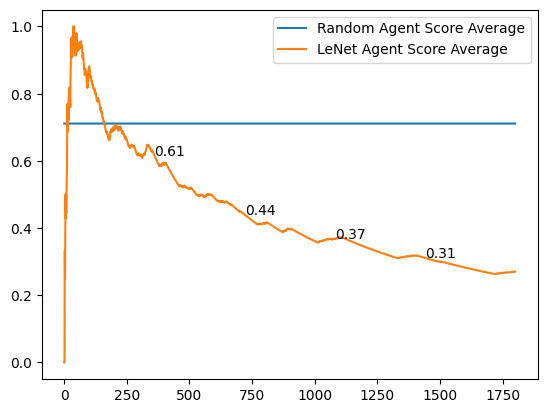

In [ ]:
random_actions_avg, lenet_actions_avg = [], []
totals = 0
count = 0
for idx, score in enumerate(random_score):
    count += 1
    totals += score
avg_random = totals / count
decision_rounds = []
count = 0
totals = 0
for idx, score in enumerate(lenet_score):
    count += 1
    decision_rounds.append(count)
    totals += score
    avg = totals / count
    lenet_actions_avg.append(avg)
    random_actions_avg.append(avg_random)

legend_interval = round(len(decision_rounds) / 5)
index = 0
for a,b in zip(decision_rounds, lenet_actions_avg):
    if index % legend_interval == 0 and index > 0:
        plt.text(a, b, f"{b:.2f}")
    index += 1
plt.plot(decision_rounds, random_actions_avg, label = "Random Agent Score Average")
plt.plot(decision_rounds, lenet_actions_avg, label = "LeNet Agent Score Average")
plt.legend()
plt.show()

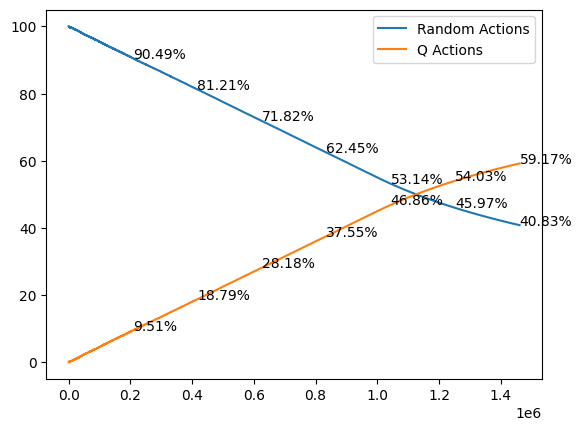

In [ ]:
random_actions_totals, lenet_actions_totals = [], []
totals = 0
decision_rounds = []
count = 0
for idx, score in enumerate(lenet_agent.random_actions_taken):
    count += 1
    decision_rounds.append(count)
    totals += score
    random_actions_totals.append(totals / count * 100)
totals = 0
count = 0
for idx, score in enumerate(lenet_agent.q_action_taken):
    count += 1
    totals += score
    lenet_actions_totals.append(totals / count * 100)
plt.plot(decision_rounds, random_actions_totals, label = "Random Actions")
plt.plot(decision_rounds, lenet_actions_totals, label = "Q Actions")
legend_interval = round(len(decision_rounds) / 7)
total_lines = len(decision_rounds)
index = 0
for a,b in zip(decision_rounds, lenet_actions_totals):
    if index % legend_interval == 0 and index > 0:
      plt.text(a, b, f"{b:.2f}%")
    if index == total_lines - 1:
        plt.text(a, b, f"{b:.2f}%")
    index += 1
index = 0
for a,b in zip(decision_rounds, random_actions_totals):
    if index % legend_interval == 0 and index > 0:
      plt.text(a, b, f"{b:.2f}%")
    if index == total_lines - 1:
        plt.text(a, b, f"{b:.2f}%")
    index += 1
plt.legend()
plt.show()

In [ ]:
# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/Reinforcement Learning"

# Write a Random Agent scores to file
with open('/content/drive/My Drive/Reinforcement Learning/Random Agent Results v2.csv', 'w') as f:
  f.write('Game,Score\n')
  for idx, score in enumerate(random_score):
      count += 1
      f.write(f'{idx},{score}\n')

# Write a LeNet Agent scores to file
with open('/content/drive/My Drive/Reinforcement Learning/LeNet Agent Results v2.csv', 'w') as f:
  f.write('Game,Score\n')
  for idx, score in enumerate(lenet_score):
      count += 1
      f.write(f'{idx},{score}\n')

# Write a Random Agent actions history
with open('/content/drive/My Drive/Reinforcement Learning/Random Agent Actions History v2.csv', 'w') as f:
  f.write('Round,Action\n')
  for idx, score in enumerate(random_actions_totals):
      count += 1
      f.write(f'{idx};{score}\n')

# Write a LeNet Agent actions history
with open('/content/drive/My Drive/Reinforcement Learning/LeNet Agent History v2.csv', 'w') as f:
  f.write('Round,Action\n')
  for idx, score in enumerate(lenet_actions_totals):
      count += 1
      f.write(f'{idx};{score}\n')

In [ ]:
import joblib

joblib.dump(lenet_agent, '/content/drive/My Drive/Reinforcement Learning/LeNet Agent v2.txt')
joblib.dump(random_agent, '/content/drive/My Drive/Reinforcement Learning/Randomd Agent v2.txt')
joblib.dump(game_play, '/content/drive/My Drive/Reinforcement Learning/Game Play v2.txt')


['/content/drive/My Drive/Reinforcement Learning/Game Play v2.txt']

In [ ]:
print(f'Max Lenet Score: {max(lenet_score)}')
print(f'Max Random Score: {max(random_score)}')
print(f'Avg Lenet Score: {sum(lenet_score)/len(lenet_score)}')
print(f'Avg Random Score: {sum(random_score)/len(random_score)}')

Max Lenet Score: 4.0
Max Random Score: 3.0
Avg Lenet Score: 0.27055555555555555
Avg Random Score: 0.7111111111111111
